In [1]:
!python --version

Python 3.11.5


In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow will run on GPU.")
else:
    print("TensorFlow will run on CPU.")

Num GPUs Available:  1
TensorFlow will run on GPU.


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


/N/soft/sles15/deeplearning/Python-3.11.5/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
import pandas as pd

# Load the dataset
data_path = '../data/processed/cleaned_diabetes_one_hot_encoding.csv'
df = pd.read_csv(data_path)

# Display the first few rows of the dataframe
print(df.head())

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  gender_Female  gender_Male  gender_Other  \
0         0              1            0             0   
1         0              1            0             0   
2         0              0            1             0   
3         0              1            0             0   
4         0              0            1             0   

   smoking_history_No Info  smoking_history_current  smoking_history_former  \
0                        0                        0                       0   
1           

In [7]:
# Normalizing the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X = df.drop('diabetes', axis=1)
Y = df['diabetes'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data with the same scaler
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [8]:
# Build the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np


model = Sequential()
model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, roc_auc_score

# Add precision and recall to the model's metrics
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

# Train the model
history = model.fit(
    X_train_scaled, Y_train, 
    epochs=100, 
    batch_size=64, 
    validation_split=0.2, 
    verbose=2
)

# Evaluate the model on the test set with additional metrics
loss, accuracy, precision, recall = model.evaluate(X_test_scaled, Y_test, verbose=2)
print(f'Test Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

# For F1-score and ROC-AUC, use sklearn's utilities as they're not directly supported as Keras metrics during training
from sklearn.metrics import f1_score, roc_auc_score

# Predict probabilities for ROC AUC
y_probs = model.predict(X_test_scaled)[:, 0]  # assuming your model outputs probabilities for class 1

# Predict class labels for F1 score and other metrics
y_pred = (y_probs > 0.5).astype('int32')

# Calculate F1 score
f1 = f1_score(Y_test, y_pred)
print(f'F1 Score: {f1:.2f}')

# Calculate ROC AUC Score
roc_auc = roc_auc_score(Y_test, y_probs)
print(f'ROC AUC Score: {roc_auc:.2f}')

Epoch 1/100
893/893 - 8s - loss: 0.2321 - accuracy: 0.9326 - precision: 0.7583 - recall: 0.1353 - val_loss: 0.1240 - val_accuracy: 0.9602 - val_precision: 0.8974 - val_recall: 0.5172 - 8s/epoch - 9ms/step
Epoch 2/100
893/893 - 3s - loss: 0.1112 - accuracy: 0.9624 - precision: 0.8954 - recall: 0.5593 - val_loss: 0.1051 - val_accuracy: 0.9642 - val_precision: 0.8943 - val_recall: 0.5811 - 3s/epoch - 3ms/step
Epoch 3/100
893/893 - 3s - loss: 0.1052 - accuracy: 0.9641 - precision: 0.8683 - recall: 0.6093 - val_loss: 0.1044 - val_accuracy: 0.9651 - val_precision: 0.9044 - val_recall: 0.5868 - 3s/epoch - 3ms/step
Epoch 4/100
893/893 - 3s - loss: 0.1045 - accuracy: 0.9647 - precision: 0.8715 - recall: 0.6159 - val_loss: 0.1044 - val_accuracy: 0.9648 - val_precision: 0.8480 - val_recall: 0.6336 - 3s/epoch - 3ms/step
Epoch 5/100
893/893 - 3s - loss: 0.1043 - accuracy: 0.9648 - precision: 0.8709 - recall: 0.6173 - val_loss: 0.1034 - val_accuracy: 0.9644 - val_precision: 0.8444 - val_recall: 0.63

##### Refined LTSM Model

In [10]:
# Build the LSTM Model
model = Sequential([
    LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(25),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.keras', verbose=1)
]

# Train the model
history = model.fit(
    X_train_scaled, Y_train, 
    epochs=100, 
    batch_size=64, 
    validation_split=0.2, 
    callbacks=callbacks,
    verbose=2
)

# Load the best model
model.load_weights('best_model.keras')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, Y_test, verbose=2)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Predict class labels for F1 score and other metrics
y_probs = model.predict(X_test_scaled)[:, 0]
y_pred = (y_probs > 0.5).astype('int32')

# Calculate F1 score and ROC AUC Score
f1 = f1_score(Y_test, y_pred)
roc_auc = roc_auc_score(Y_test, y_probs)
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')

Epoch 1/100

Epoch 1: saving model to best_model.keras
893/893 - 12s - loss: 0.1638 - accuracy: 0.9495 - val_loss: 0.1090 - val_accuracy: 0.9652 - 12s/epoch - 13ms/step
Epoch 2/100

Epoch 2: saving model to best_model.keras
893/893 - 5s - loss: 0.1207 - accuracy: 0.9603 - val_loss: 0.1118 - val_accuracy: 0.9644 - 5s/epoch - 5ms/step
Epoch 3/100

Epoch 3: saving model to best_model.keras
893/893 - 5s - loss: 0.1167 - accuracy: 0.9616 - val_loss: 0.1033 - val_accuracy: 0.9660 - 5s/epoch - 6ms/step
Epoch 4/100

Epoch 4: saving model to best_model.keras
893/893 - 5s - loss: 0.1136 - accuracy: 0.9617 - val_loss: 0.1028 - val_accuracy: 0.9654 - 5s/epoch - 6ms/step
Epoch 5/100

Epoch 5: saving model to best_model.keras
893/893 - 5s - loss: 0.1120 - accuracy: 0.9627 - val_loss: 0.1013 - val_accuracy: 0.9663 - 5s/epoch - 6ms/step
Epoch 6/100

Epoch 6: saving model to best_model.keras
893/893 - 5s - loss: 0.1109 - accuracy: 0.9633 - val_loss: 0.1070 - val_accuracy: 0.9639 - 5s/epoch - 6ms/step
E

#### Handling Class Imbalance

In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights for balanced training
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weight_dict = dict(enumerate(class_weights))

# Retrain model with class weights
history = model.fit(
    X_train_scaled, Y_train,
    epochs=100, 
    batch_size=64,
    validation_split=0.2,
    verbose=2,
    class_weight=class_weight_dict
)

Epoch 1/100
893/893 - 7s - loss: 0.2199 - accuracy: 0.9077 - val_loss: 0.1698 - val_accuracy: 0.9113 - 7s/epoch - 8ms/step
Epoch 2/100
893/893 - 5s - loss: 0.2051 - accuracy: 0.8983 - val_loss: 0.1862 - val_accuracy: 0.8985 - 5s/epoch - 5ms/step
Epoch 3/100
893/893 - 5s - loss: 0.2037 - accuracy: 0.8966 - val_loss: 0.1886 - val_accuracy: 0.8937 - 5s/epoch - 5ms/step
Epoch 4/100
893/893 - 5s - loss: 0.2025 - accuracy: 0.8948 - val_loss: 0.1736 - val_accuracy: 0.9067 - 5s/epoch - 6ms/step
Epoch 5/100
893/893 - 5s - loss: 0.2031 - accuracy: 0.8977 - val_loss: 0.2037 - val_accuracy: 0.8817 - 5s/epoch - 5ms/step
Epoch 6/100
893/893 - 5s - loss: 0.2001 - accuracy: 0.8962 - val_loss: 0.1873 - val_accuracy: 0.8977 - 5s/epoch - 6ms/step
Epoch 7/100
893/893 - 5s - loss: 0.2012 - accuracy: 0.8956 - val_loss: 0.1792 - val_accuracy: 0.9003 - 5s/epoch - 6ms/step
Epoch 8/100
893/893 - 5s - loss: 0.2033 - accuracy: 0.8949 - val_loss: 0.1794 - val_accuracy: 0.9002 - 5s/epoch - 5ms/step
Epoch 9/100
893/

#### Architecture Refinement

In [12]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))  # Another Dropout layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

In [13]:
# Evaluate the refined model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test_scaled, Y_test, verbose=2)
print(f'Refined Model Test Accuracy: {accuracy*100:.2f}%')
print(f'Refined Model Precision: {precision:.2f}')
print(f'Refined Model Recall: {recall:.2f}')

# Calculate and print F1 score and ROC AUC for the refined model
y_probs_refined = model.predict(X_test_scaled)[:, 0]  # assuming your model outputs probabilities for class 1
y_pred_refined = (y_probs_refined > 0.5).astype('int32')

# F1 Score
f1_refined = f1_score(Y_test, y_pred_refined)
print(f'Refined Model F1 Score: {f1_refined:.2f}')

# ROC AUC Score
roc_auc_refined = roc_auc_score(Y_test, y_probs_refined)
print(f'Refined Model ROC AUC Score: {roc_auc_refined:.2f}')


558/558 - 3s - loss: 0.6928 - accuracy: 0.4965 - precision_1: 0.0473 - recall_1: 0.2971 - 3s/epoch - 5ms/step
Refined Model Test Accuracy: 49.65%
Refined Model Precision: 0.05
Refined Model Recall: 0.30
558/558 [==============================] - 2s 1ms/step
Refined Model F1 Score: 0.08
Refined Model ROC AUC Score: 0.36


#### Hyperparameter Tuning

In [14]:
!pip install keras-tuner

/N/soft/sles15/deeplearning/Python-3.11.5/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable


In [15]:
from keras_tuner import RandomSearch
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
                   return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='diabetes_prediction'
)

tuner.search(X_train_scaled, Y_train, epochs=10, validation_data=(X_test_scaled, Y_test))
best_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from my_dir/diabetes_prediction/tuner0.json


558/558 [==============================] - 2s 2ms/step


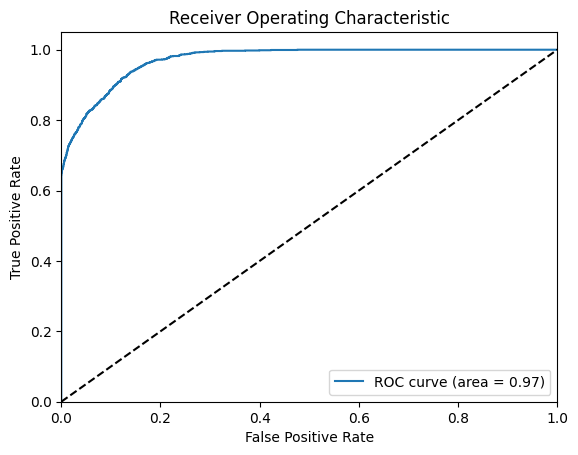

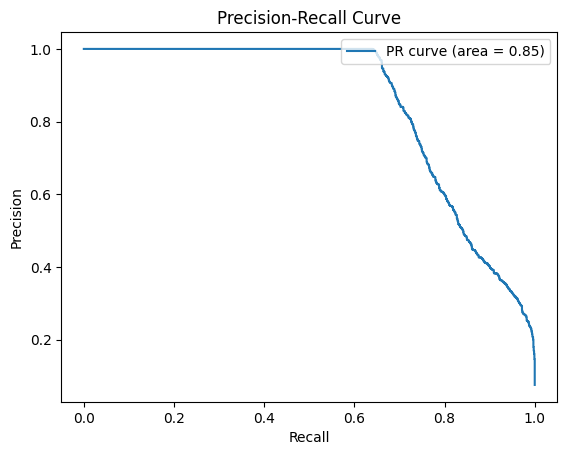

In [16]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# ROC Curve
y_probs = best_model.predict(X_test_scaled)[:, 0]
fpr, tpr, thresholds = roc_curve(Y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test, y_probs)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()